In [9]:
# !pip install scikit-image
# !pip install opencv-python

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.utils import load_img, img_to_array, to_categorical
import cv2
from skimage.restoration import denoise_nl_means, estimate_sigma
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense
#from keras.applications.efficientnet import EfficientNetB0, preprocess_input as preprocess_efficientnetB0
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_resnet50
from keras.applications.inception_v3 import InceptionV3, preprocess_input as preprocess_inceptionv3
from keras.models import Model
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from keras.preprocessing.image import ImageDataGenerator

os.getcwd()

'D:\\UofT\\MMA\\RSM8521\\RSM8521_FinalProject_Team6'

In [43]:
from tensorflow.keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, MobileNet, EfficientNetB0
from tensorflow.keras.metrics import AUC
import math
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [12]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

# 1. Parameter Definition

In [13]:
# model_list = ['ResNet50', 'VGG16', 'InceptionV3', 'MobileNet', 'EfficientNetB0']
model_in_training = 'MobileNet'
num_filters = 32

In [14]:
hypertuning_flag == True
seed = 22

In [15]:
# Example path
path_temp = f'Alzheimer_s Dataset/train/NonDemented/'

# data path
train_data_dir = r'Alzheimer_s Dataset/train'
test_data_dir = r'Alzheimer_s Dataset/test'

In [16]:
# The desired image augmentation we want to apply 
datagen = ImageDataGenerator(
    rotation_range=15,      # Randomly rotate images by up to 10 degrees
    width_shift_range=0.05,  # Randomly shift images horizontally by up to 10% of the image width
    height_shift_range=0.05, # Randomly shift images vertically by up to 10% of the image height
    shear_range=0.05,        # Randomly shear images by up to 20%
    zoom_range=0.005,         # Randomly zoom images by up to 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=True,    # Do not flip images vertically
#     brightness_range= (0.8, 1.2),
    fill_mode='nearest'     # Fill any missing pixels with the nearest pixel value
)

In [17]:
# Set your training parameters
epochs = 20
batch_size = 32

# 2. Function Definition

In [18]:
# Increase Contrast
def contrast_adjustment(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    adjusted_image = clahe.apply(img_gray)
    return cv2.cvtColor(adjusted_image, cv2.COLOR_GRAY2RGB)

In [19]:
# noise reduction
def denoise_image(image, h=5):
    src = np.uint8(image)  # Convert image to 8-bit unsigned integers
    denoised_image = cv2.fastNlMeansDenoisingColored(src, None, h=h, templateWindowSize=7, searchWindowSize=21)
    return denoised_image

In [20]:
# intensity normalization
def normalize_intensity(image):
    original_shape = image.shape
    reshaped_img = image.reshape(-1,1)
    scaler = MinMaxScaler()
    normalized_image = scaler.fit_transform(reshaped_img)
    return normalized_image.reshape(original_shape)

In [21]:
# get dimensions if resize for the pre-trained model is needed
def get_size(model):
    """
    This function will instantiate the default image size used for training
    for the choice pre-trained model
        input: model choice - string
        output: img_width, img_height
    """
    if model == 'InceptionV3':
        img_width, img_height = 299, 299
    elif (model == 'ResNet50') | (model == 'VGG16')|(model == 'EfficientNetB0')|(model == 'MobileNet'):
        img_width, img_height = 224, 224
    return img_width, img_height

In [22]:
def load_img_data(data_dir, resize_option, resize_dim):
    """
    This function extracts image data, apply preprocess steps, and convert them into numpy array
        inputs: data_dir: data directory, train or test (string)
                resize_option: resize or keep orginal size (boolean)
                resize_width, resize_height: outputs from "get_size", only be used when resize_option is True; Otherwise, orginal size will be used
        output: numpy arrary of each image with associated label

    """
#     num_files_to_access = 200
    file_counter = 0

    images = []
    labels = []
    num_images_processed = 0
    for class_name in os.listdir(data_dir):
        class_folder = os.path.join(data_dir, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):

                '''
                The below code can help you extract only 200 images, for testing purpose
                '''
                # if file_counter >= num_files_to_access:
                #     break
                # print(filename)
                # file_counter += 1

                img_path = os.path.join(class_folder, filename)

                # Depending on the resize options specified at the beginning of the function, to choose whether or not to resize
                if resize_option == False:
                    img = load_img(img_path)
                else:
                    img = load_img(img_path, target_size=(resize_dim[0], resize_dim[1]), color_mode = 'rgb')
                img_array = img_to_array(img)

                # apply preprocessing
                denoised_image = denoise_image(img_array)
                contrast_adjusted_image = contrast_adjustment(denoised_image)
                normalized_image = normalize_intensity(contrast_adjusted_image)

                # append results to corresponding lists
                images.append(normalized_image)
                if class_name != "NonDemented":
                    labels.append('Demented')
                else:
                    labels.append(class_name)

                num_images_processed += 1
                if num_images_processed % 100 == 0:
                    print(f"Processed {num_images_processed} images")

    return np.array(images), np.array(labels)

In [23]:
# Data Augmentation
def augmentation_image(X_train, y_train, batch_size, datagen, augmentation_factor=0.5):
    '''
       This function takes Xtrain and Ytrain, which are two arrays. 
       Then, augment them based on the augmentation techniques we require above.  
    '''
    num_samples = X_train.shape[0]
    augmentation_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

    # Generate two empty arrays to store the information
    augmented_images = np.empty((0, *X_train.shape[1:]), dtype=X_train.dtype)
    augmented_labels = np.empty((0,), dtype=y_train.dtype)
    
    num_batches = num_samples // batch_size + 1
    total_batches = math.ceil(num_batches * augmentation_factor)
#     total_batches = math.ceil(num_samples / batch_size)

    for i in range(total_batches):
        x_batch, y_batch = augmentation_generator.next()
        augmented_images = np.concatenate((augmented_images, x_batch))
        augmented_labels = np.concatenate((augmented_labels, y_batch))

    return augmented_images, augmented_labels

In [24]:
# class PlotAUC(keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.aucs = []

#     def on_epoch_end(self, epoch, logs={}):
#         self.aucs.append(logs.get('auc'))
#         clear_output(wait=True)
#         plt.figure(figsize=(12, 6))
#         plt.plot(range(1, epoch + 2), self.aucs, marker='o')
#         plt.xlabel('Epochs')
#         plt.ylabel('AUC Score')
#         plt.title('Training AUC Score vs Epochs')
#         plt.xticks(range(1, epoch + 2))
#         plt.grid()
#         plt.show()

In [ ]:
class PlotAUC(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_aucs = []
        self.val_aucs = []

    def on_epoch_end(self, epoch, logs={}):
        self.train_aucs.append(logs.get('auc'))
        self.val_aucs.append(logs.get('val_auc'))
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, epoch + 2), self.train_aucs, marker='o', label='Training AUC')
        plt.plot(range(1, epoch + 2), self.val_aucs, marker='o', label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC Score')
        plt.title('Training and Validation AUC Score vs Epochs')
        plt.xticks(range(1, epoch + 2))
        plt.legend()
        plt.grid()
        plt.show()

### Data Preprocessing
To ensure the quality of the input data, we considered several preprocessing techniques that are specifically tailored for MRI images and have been widely used in neuroimaging research, including noise reduction, intensity normalization, and brain extraction. Each of these steps address different realistic challenges and reduce heterogeneities other than the key features from MRI images. These techniques will help ensure that the MRI data is suitable for machine learning models, improving their performance and generalization.<br>
1. **Noise reduction:**<br>
MRI images can contain noises, artifacts, or non-uniformities that could cause the model to overfit on these irrelevant/biased features.<br>

2. **Intensity normalization:**<br>
The intensity values of MRI images can vary across different scanners, subjects, or sessions. Therefore, normalization is essential for ensuring that the features extracted by the model are consistent across the dataset.<br>

## Preprocessing Examples

### Increase Contrast

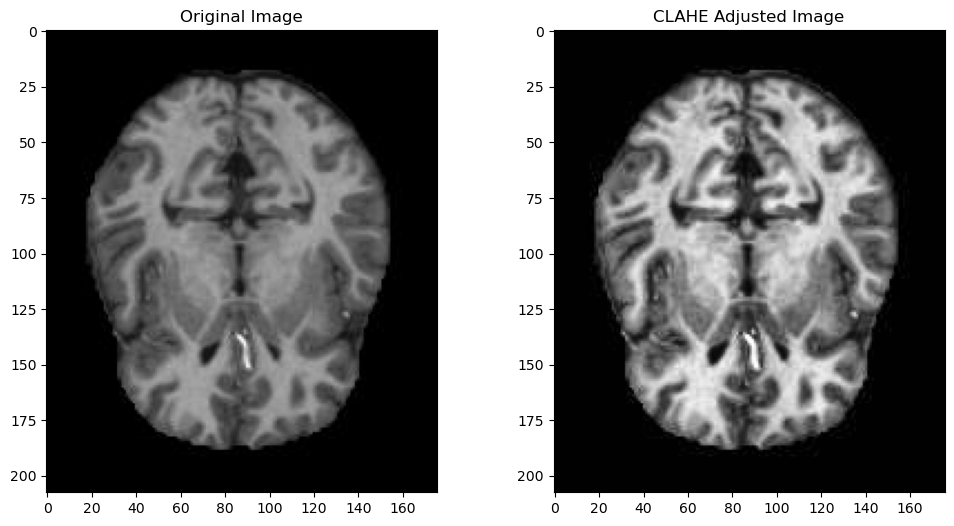

In [25]:
# Read the input image in grayscale
img = cv2.imread(path_temp + 'nonDem12.jpg', 0)

# Create a CLAHE object with specified parameters
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Apply CLAHE to the input image
clahe_img = clahe.apply(img)

# Display the original and adjusted images
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(clahe_img, cmap='gray')
plt.title('CLAHE Adjusted Image')

plt.show()

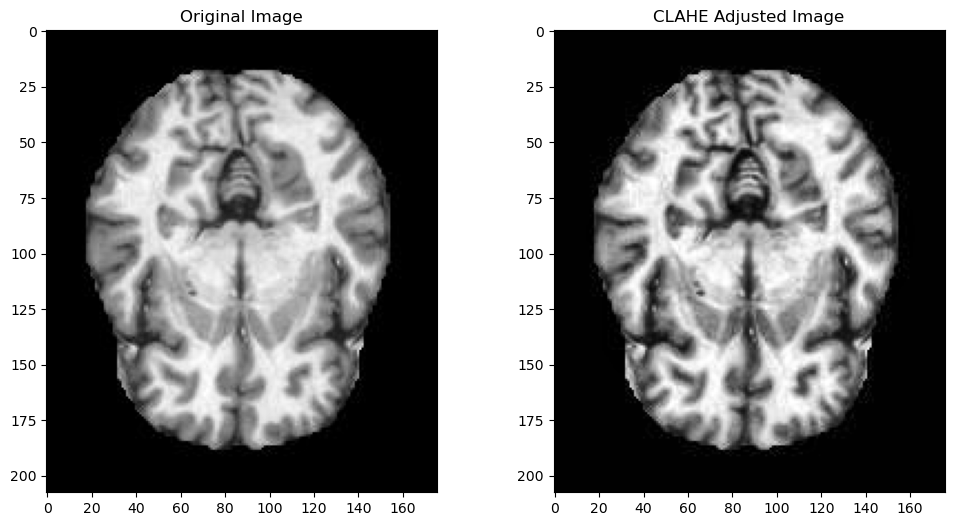

In [26]:
# Read the input image in grayscale
img = cv2.imread(path_temp + 'nonDem11.jpg', 0)

# Create a CLAHE object with specified parameters
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Apply CLAHE to the input image
clahe_img = clahe.apply(img)

# Display the original and adjusted images
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(clahe_img, cmap='gray')
plt.title('CLAHE Adjusted Image')

plt.show()

### Denoising

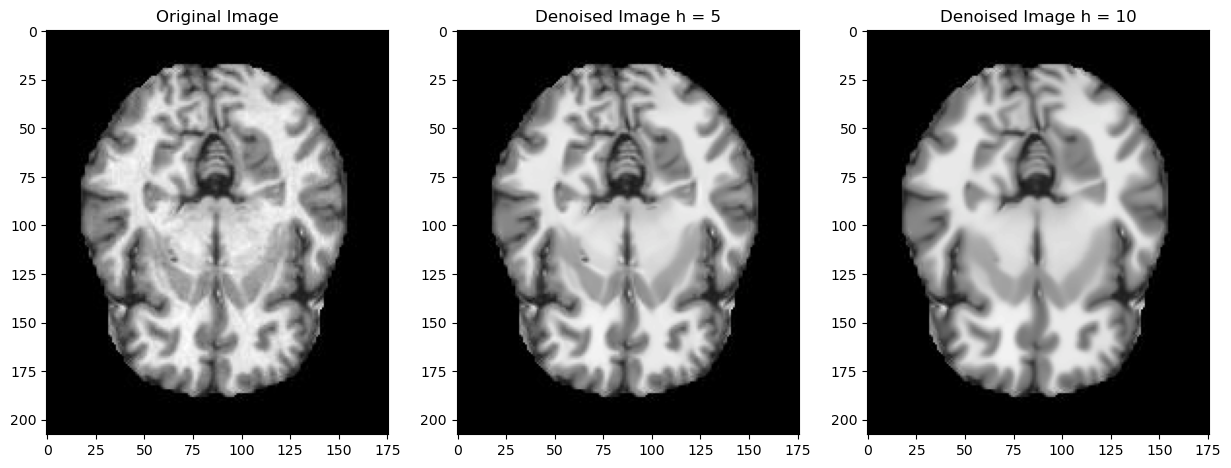

In [27]:
# Read the input image in grayscale
img = cv2.imread(path_temp + 'nonDem11.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Denoise the image
denoised_img_5 = denoise_image(img, h=5)
denoised_img_10 = denoise_image(img, h=10)

# Display the original and denoised images
plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(132)
plt.imshow(denoised_img_5)
plt.title('Denoised Image h = 5')

plt.subplot(133)
plt.imshow(denoised_img_10)
plt.title('Denoised Image h = 10')

plt.show()

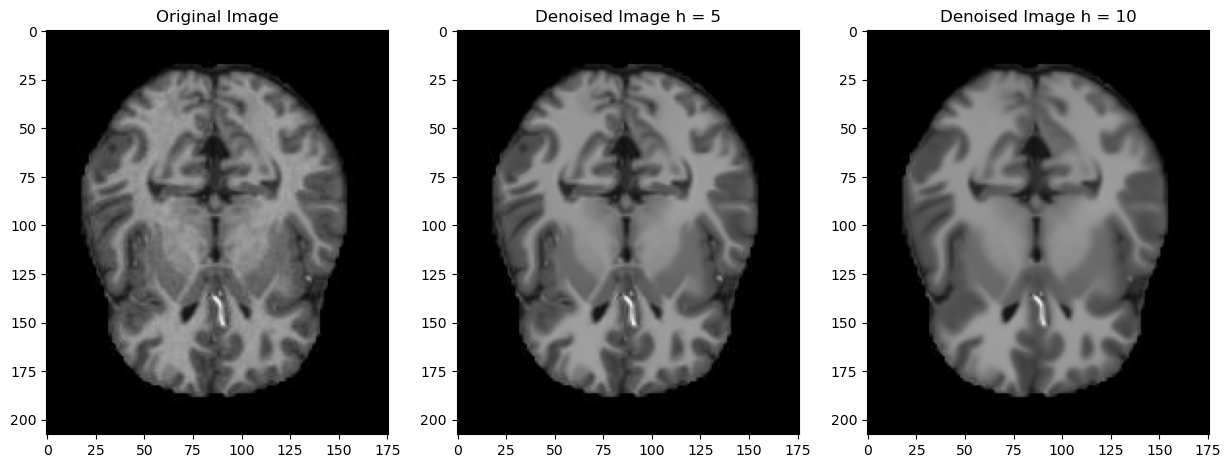

In [28]:
# Read the input image in grayscale
img = cv2.imread(path_temp + 'nonDem12.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Denoise the image
denoised_img_5 = denoise_image(img, h=5)
denoised_img_10 = denoise_image(img, h=10)

# Display the original and denoised images
plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(132)
plt.imshow(denoised_img_5)
plt.title('Denoised Image h = 5')

plt.subplot(133)
plt.imshow(denoised_img_10)
plt.title('Denoised Image h = 10')

plt.show()

### Normalizing Intensity

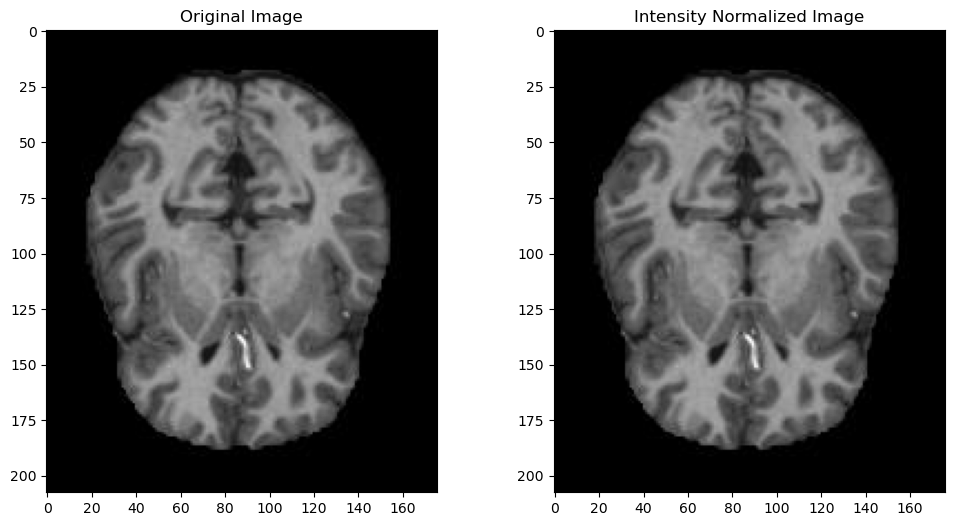

In [29]:
# Load the image in grayscale mode
img = cv2.imread(path_temp + 'nonDem12.jpg', cv2.IMREAD_GRAYSCALE)

# Normalize the intensity of the image
normalized_img = normalize_intensity(img)

# Display the original and normalized images
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(normalized_img, cmap='gray')
plt.title('Intensity Normalized Image')

plt.show()

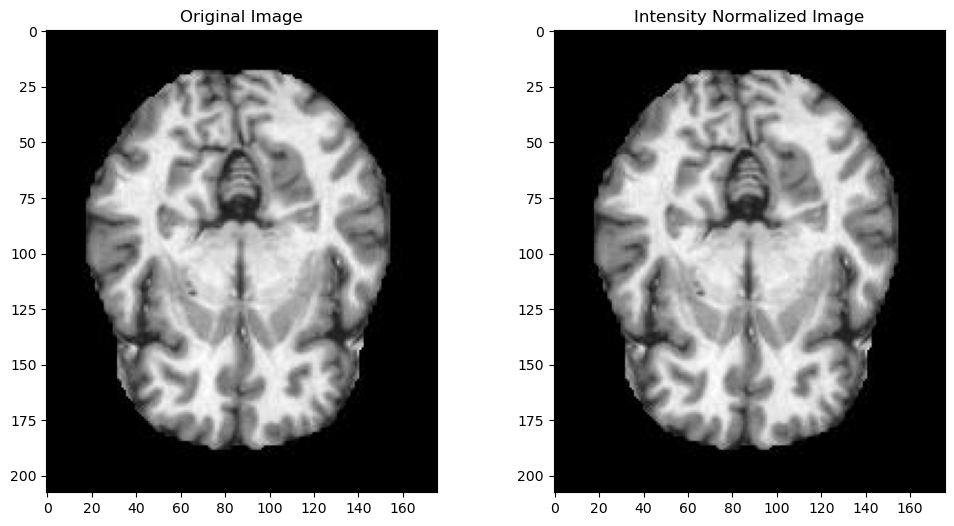

In [30]:
# Load the image in grayscale mode
img = cv2.imread(path_temp + 'nonDem11.jpg', cv2.IMREAD_GRAYSCALE)

# Normalize the intensity of the image
normalized_img = normalize_intensity(img)

# Display the original and normalized images
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(normalized_img, cmap='gray')
plt.title('Intensity Normalized Image')

plt.show()

### Example of Augmented Image

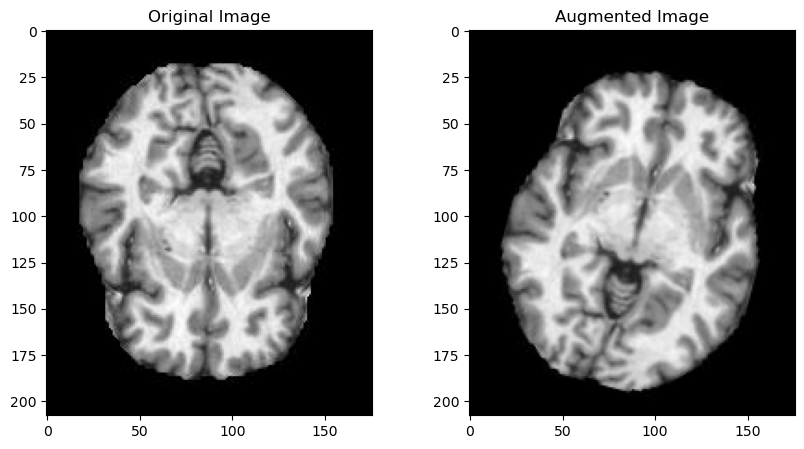

In [31]:
def single_image_augmentation(img, datagen):
    img = np.expand_dims(img, axis=0)  # Add a batch dimension to the image

    augmentation_generator = datagen.flow(img, batch_size=1)

    # Get a single augmented image
    augmented_image = augmentation_generator.next()[0]

    return augmented_image

# Load an image
img = cv2.imread(path_temp + 'nonDem11.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Apply augmentation to the image
augmented_img = single_image_augmentation(img, datagen)

# Display original and augmented images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[1].imshow(augmented_img.astype('uint8'))
axes[1].set_title('Augmented Image')

plt.show()

# 3. Model Training

## 3.1 Data loading

In [32]:
resize_dim = get_size(model_in_training)

In [33]:
# Load data for training set
X_tr, y_tr = load_img_data(train_data_dir, False, resize_dim)

Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images
Processed 1000 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1600 images
Processed 1700 images
Processed 1800 images
Processed 1900 images
Processed 2000 images
Processed 2100 images
Processed 2200 images
Processed 2300 images
Processed 2400 images
Processed 2500 images
Processed 2600 images
Processed 2700 images
Processed 2800 images
Processed 2900 images
Processed 3000 images
Processed 3100 images
Processed 3200 images
Processed 3300 images
Processed 3400 images
Processed 3500 images
Processed 3600 images
Processed 3700 images
Processed 3800 images
Processed 3900 images
Processed 4000 images
Processed 4100 images
Processed 4200 images
Processed 4300 images
Processed 4400 images
Processed 4500 images
Processed 4600 imag

In [ ]:
# Load data for testing set
X_test, y_test = load_img_data(test_data_dir, False, resize_dim)

In [ ]:
y_test = np.where(y_test == 'Demented', 1, 0)

In [ ]:
# Change the target variable into one-hot encoding for softmax and gridsearch
# label_encoder = LabelEncoder()

# train validation split
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state=seed)

y_train_binary = np.where(y_train == 'Demented', 1, 0)
y_validation_binary = np.where(y_val == 'Demented', 1, 0)

print(X_train.shape)
print(y_train_binary.shape)

## 3.2 Data Augmentation

In [ ]:
batch_size = 32

train_datagen = ImageDataGenerator(datagen)
validation_datagen = ImageDataGenerator()


train_generator = train_datagen.flow(X_train, 
                                     y_train_binary, 
                                     batch_size = batch_size)

validation_generator = validation_datagen.flow(X_val, 
                                               y_validation_binary, 
                                               batch_size = batch_size)

In [ ]:
# Get a batch of 32 augmented images and labels
augmented_images_batch, augmented_labels_batch = train_generator.next()
train_generator.reset()

# Display the 32 augmented images
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(24, 12))
for i in range(4):
    for j in range(8):
        ax[i][j].imshow(augmented_images_batch[i * 8 + j].astype(np.uint8))
        ax[i][j].set_title(str(augmented_labels_batch[i * 8 + j]))
        ax[i][j].axis('off')
plt.show()

In [35]:
# # Set your desired batch size and augmentation factor
# batch_size = 32
# augmentation_factor = 0.5  # You can change this to the desired factor

# # Generate augmented images and labels
# X_train_aug, y_train_aug = augmentation_image(X_train, y_train = y_train_binary, datagen = datagen, 
#                                               batch_size = batch_size, augmentation_factor = augmentation_factor)

# # Combine original and augmented data
# X_train = np.concatenate((X_train, X_train_aug), axis=0)
# y_train = np.concatenate((y_train_binary, y_train_aug), axis=0)

# print(X_train.shape)
# print(y_train.shape)

(6176, 208, 176, 3)
(6176,)


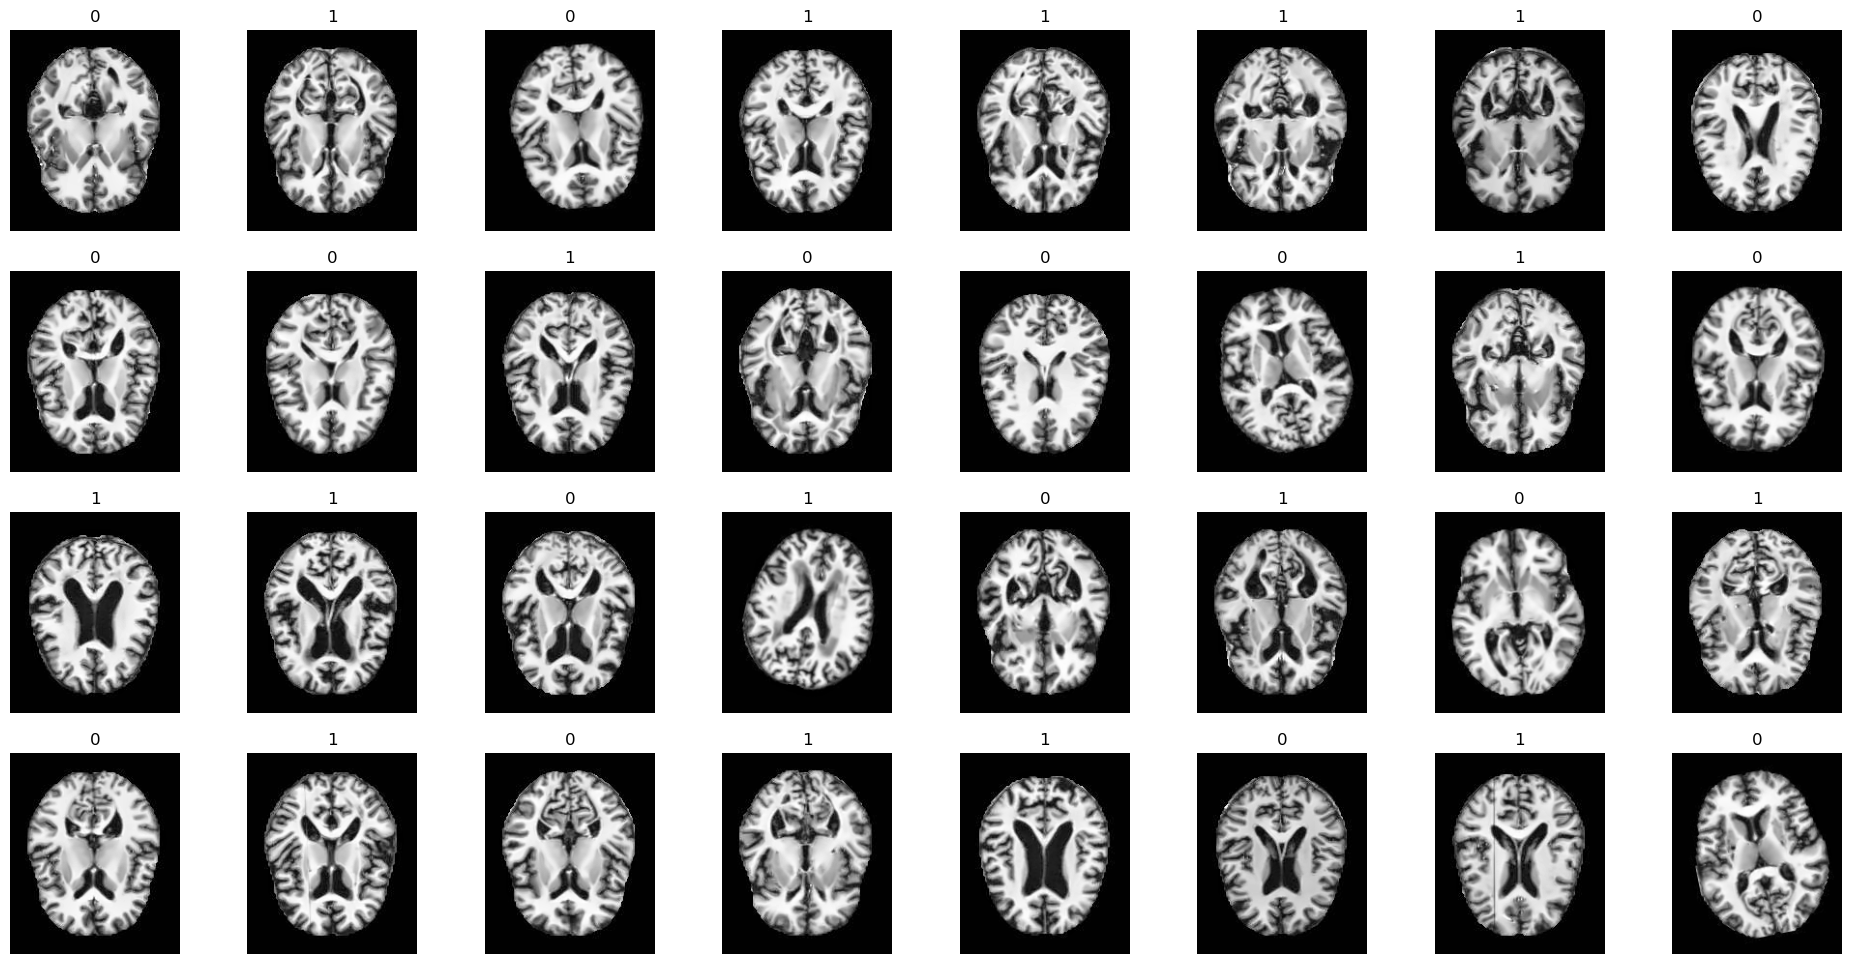

In [36]:
# Take a look at the images if you want to, randomly select images

num_images = 32
indices = np.random.choice(len(X_train), num_images)
images = X_train[indices]
labels = y_train_binary[indices]


fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(24,12))
for i in range(4):
    for j in range(8):
        ax[i][j].imshow(images[i*8+j])
        ax[i][j].set_title(str(labels[i*8+j]))
        ax[i][j].axis('off')
plt.show()

## 3.3 Model Construction

In [37]:
def create_model(base_model, num_conv_layers=1, num_filters=64, filter_size=(5, 5), 
                 dropout_rate=0.5, use_custom_layers=True, fc_layer_size = 128):
    """
    This function constructs the CNN model based on the specified pre-trained model
    and adds tailored, appropriate fully connected layers for each base model
    along with custom Conv2D layers and a GlobalAveragePooling2D layer, if enabled.
    """
    base = MobileNet(weights='imagenet', include_top=False)

    # Freeze the base model layers
    for layer in base.layers:
        layer.trainable = False

    # Fine-tune the model with custom layers
    x = base.output

    if use_custom_layers:
        for _ in range(num_conv_layers):
            x = Conv2D(num_filters, filter_size, padding='same', activation='relu')(x)
            x = Dropout(dropout_rate)(x)

        x = GlobalAveragePooling2D()(x)
    else:
        x = Flatten()(x)

    x = Dense(fc_layer_size, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(fc_layer_size, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[AUC(name='auc')])

    return model

# Example usage
create_model(model_in_training, 
             num_conv_layers=2,
             use_custom_layers=True).summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                    

                                                                 
 conv_pw_8 (Conv2D)          (None, None, None, 512)   262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, None, None, 512)  2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, None, None, 512)   0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, None, None, 512)  4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, None, None, 512)  2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, None, None, 512)   0         
                                                                 
 conv_pw_9

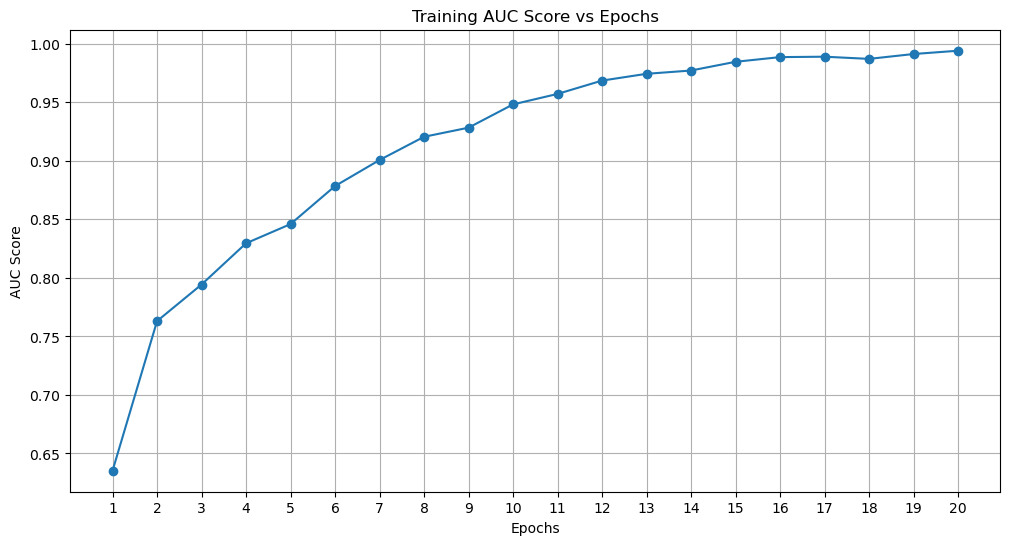

193/193 [==============================] - 46s 237ms/step - loss: 0.0976 - auc: 0.9941


In [38]:
if hypertuning_flag == False:
    # Create the model
    model = create_model(model_in_training, 
                         num_conv_layers=2,
                         use_custom_layers=True)

    # Instantiate the custom callback
    plot_callback = PlotAUC()

    # Train the model
    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs=epochs,
                        batch_size=batch_size,
                        steps_per_epoch = (len(X_train)//batch_size),
                        callbacks=[plot_callback])

# 4. Evaluation

In [39]:
if hypertuning_flag == False:
    test_loss, test_auc = model.evaluate(X_test, y_test, verbose=1)

    print("Test Loss:", test_loss)
    print("Test AUC:", test_auc)

33/33 [==============================] - 7s 200ms/step - loss: 0.3987 - auc: 0.9495
Test Loss: 0.3987063765525818
Test AUC: 0.9495306611061096


In [40]:
if hypertuning_flag == False:
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred >= 0.5, 1, 0)
    conf_mat = confusion_matrix(y_test, y_pred_binary)

    print("Confusion Matrix:")
    print(conf_mat)

33/33 [==============================] - 7s 190ms/step
Confusion Matrix:
[[466  36]
 [ 90 433]]


In [46]:
# param_dict = {
# #     'num_conv_layers': [1, 2, 3],
#     'num_filters': [num_filters],
#     'filter_size': [(3, 3), (5, 5)],
#     'dropout_rate': [0.3, 0.5, 0.6]
# #     'use_custom_layers': [True, False],
# #     'fc_layer_size': [128, 256, 512] 
# }

# 5. Hyperparameter Tuning

In [ ]:
param_dict = {
    'num_filters': [num_filters],
    'filter_size': [(3, 3), (5, 5)],
    'dropout_rate': [0.3, 0.5, 0.6]
}

In [ ]:
if hypertuning_flag == True:
    
    # use keras wrapper
    model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=1)

    # gridsearch
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)

    # Perform the grid search
    grid_result = grid.fit(X_train, y_train_binary)


    # Get the best model and best parameters
    best_model = grid_result.best_estimator_.model
    best_parameters = grid_result.best_params_
    
    print("Best parameters: ", best_parameters)

In [ ]:
if hypertuning_flag == True:
    
    # Choose 10 random indices from the test set
    random_indices = np.random.choice(len(X_test), 10, replace=False, seed=seed)

    # Get the 10 random images and their labels
    X_test_random = X_test[random_indices]
    y_test_random = y_test[random_indices]

    # Make predictions using the best model
    y_pred_random = best_model.predict(X_test_random)
    y_pred_random_binary = np.round(y_pred_random).flatten()

    # Display the results
    for i in range(10):
        plt.figure(figsize=(2, 2))
        plt.imshow(X_test_random[i])
        plt.axis('off')
        plt.title(f"True: {y_test_random[i]} - Predicted: {y_pred_random_binary[i]}")
        plt.show()

In [47]:
# # 2. Define the create_model_for_random_search function
# def create_model_for_random_search(base_model=model_in_training, num_conv_layers=1, num_filters=32, filter_size=(3, 3),
#                                    dropout_rate=0.5, use_custom_layers=True, fc_layer_size=128):
#     return create_model(base_model, num_conv_layers, num_filters, filter_size, dropout_rate, use_custom_layers, fc_layer_size)

# # 3. Create a KerasClassifier with the create_model_for_random_search function
# model = KerasClassifier(build_fn=create_model_for_random_search)

# # 4. Perform random search
# n_iter_search = 20  # Number of parameter settings that are sampled, adjust based on your available resources
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
#                                    n_iter=n_iter_search, cv=3, n_jobs=-1, verbose=1)

# random_search.fit(X_train, y_train)

# # Print the best hyperparameters found
# print("Best parameters found: ", random_search.best_params_)

C:\Users\ddjgy\AppData\Local\Temp\ipykernel_25044\1840338298.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model_for_random_search)
C:\Users\ddjgy\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

### Evaluate the model performance

In [ ]:
# def evaluate_model(runs=5):
#     scores = [] 
#     for i in range(runs):
#         print('Executing run %d' % (i+1))
#         model = create_model() # input the best parameters found in the previous gridsearch
#         model.fit(X_test,
#                   callbacks=[],
#                   epochs=epochs, verbose=0)
#         print(' * Evaluating model on test set')
#         scores.append(model.evaluate(y_test_encoded, 
#                                      steps = y_test_encoded.shape[0] // batch_size,
#                                      verbose=0))
#         print(' * Test set Loss: %.4f, Accuracy: %.4f' % (scores[-1][0], scores[-1][1]))
        
#     accuracies = [score[1] for score in scores]     
#     return np.mean(accuracies), np.std(accuracies)
        
# mean_accuracy, std_accuracy = evaluate_model(runs=5)